In [1]:
import sys
sys.path.insert(0, '../../')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-white')
from tqdm.notebook import tqdm
from typing import List, Tuple, Union

import candle.functions as F
import candle.optimizer

### (1) Define ResNet

In [3]:
class ResNet(candle.Module):
    
    def __init__(self,
                 n_layers: int,
                 embed_dim: int):
        super().__init__()
        self.n_layers = n_layers
        self.embed_dim = embed_dim
        
        self.layers = candle.ParameterList([Residuallayer(embed_dim) for _ in range(n_layers)])
        
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
            
        return x

    
    def init_weights(self):
        for layer in self.layers:
            layer.linear.W.data[:] = layer.linear.W.data / np.sqrt(self.n_layers)
        

class Residuallayer(candle.Module):

    def __init__(self,
                 embed_dim: int):
        super().__init__()
        self.embed_dim = embed_dim

        self.linear = candle.Linear(embed_dim, embed_dim, bias=False)
        self.norm = candle.LayerNorm(embed_dim)
        

    def forward(self, x):
        return x + self.linear(self.norm(x))


### (2) Gradient / Activation Norm By Layer

In [10]:
def activation_and_gradient_norm_by_layer(n_layers: int, input_std: float, n_trials: int = 10):
    activation_norm_df = pd.DataFrame()
    grad_norm_df = pd.DataFrame()
    
    for trial in range(n_trials):
        embed_dim = 128
        
        model = ResNet(n_layers, embed_dim)
        model.init_weights()
        
        layer_activations = {}
        def store_activations(layer_name):
            def hook_fn(module, input, output):
                layer_activations[layer_name] = np.linalg.norm(output.data)
            
            return hook_fn
            
        for (i, layer) in enumerate(model.layers):
            layer.register_forward_hook(store_activations(i))    
        
        x = candle.rand(10, embed_dim) * input_std
        y = candle.rand(10, embed_dim)
        
        output = model(x)
        
        loss = ((output - y) ** 2).sum()
        
        loss.backward()
        
        activation_norms = list(layer_activations.values())
        grad_norms = [np.linalg.norm(layer.linear.W.grad) for layer in model.layers]
    
        activation_norm_df[trial] = activation_norms
        grad_norm_df[trial] = grad_norms
        
    
    fig = plt.figure(figsize=(16, 12))
    
    ax = fig.add_subplot(2, 2, 1)
    
    activation_norm_df.mean(axis=1).plot(ax=ax)
    ax.axhline(0, color='black', linewidth=0.5)
    ax.set_xlabel('Layer')
    ax.set_ylabel('Norm')
    ax.set_title('Activation Norm by Layer')
    ax.grid(linewidth=0.5)
    
    ax = fig.add_subplot(2, 2, 2)
    
    grad_norm_df.mean(axis=1).plot(ax=ax)
    ax.axhline(0, color='black', linewidth=0.5)
    ax.set_xlabel('Layer')
    ax.set_ylabel('Norm')
    ax.set_title('Gradient Norm by Layer')
    ax.grid(linewidth=0.5)
    
    ax = fig.add_subplot(2, 2, 3)
    
    np.square(activation_norm_df.mean(axis=1)).plot(ax=ax)
    ax.axhline(0, color='black', linewidth=0.5)
    ax.set_xlabel('Layer')
    ax.set_ylabel('Norm')
    ax.set_title('Squared Activation Norm by Layer')
    ax.grid(linewidth=0.5)
    
    ax = fig.add_subplot(2, 2, 4)
    
    (1 / np.square(grad_norm_df.mean(axis=1))).plot(ax=ax)
    ax.axhline(0, color='black', linewidth=0.5)
    ax.set_xlabel('Layer')
    ax.set_ylabel('Norm')
    ax.set_title('1 / Squared Gradient Norm by Layer')
    ax.grid(linewidth=0.5)
    
    plt.tight_layout()
    plt.show()

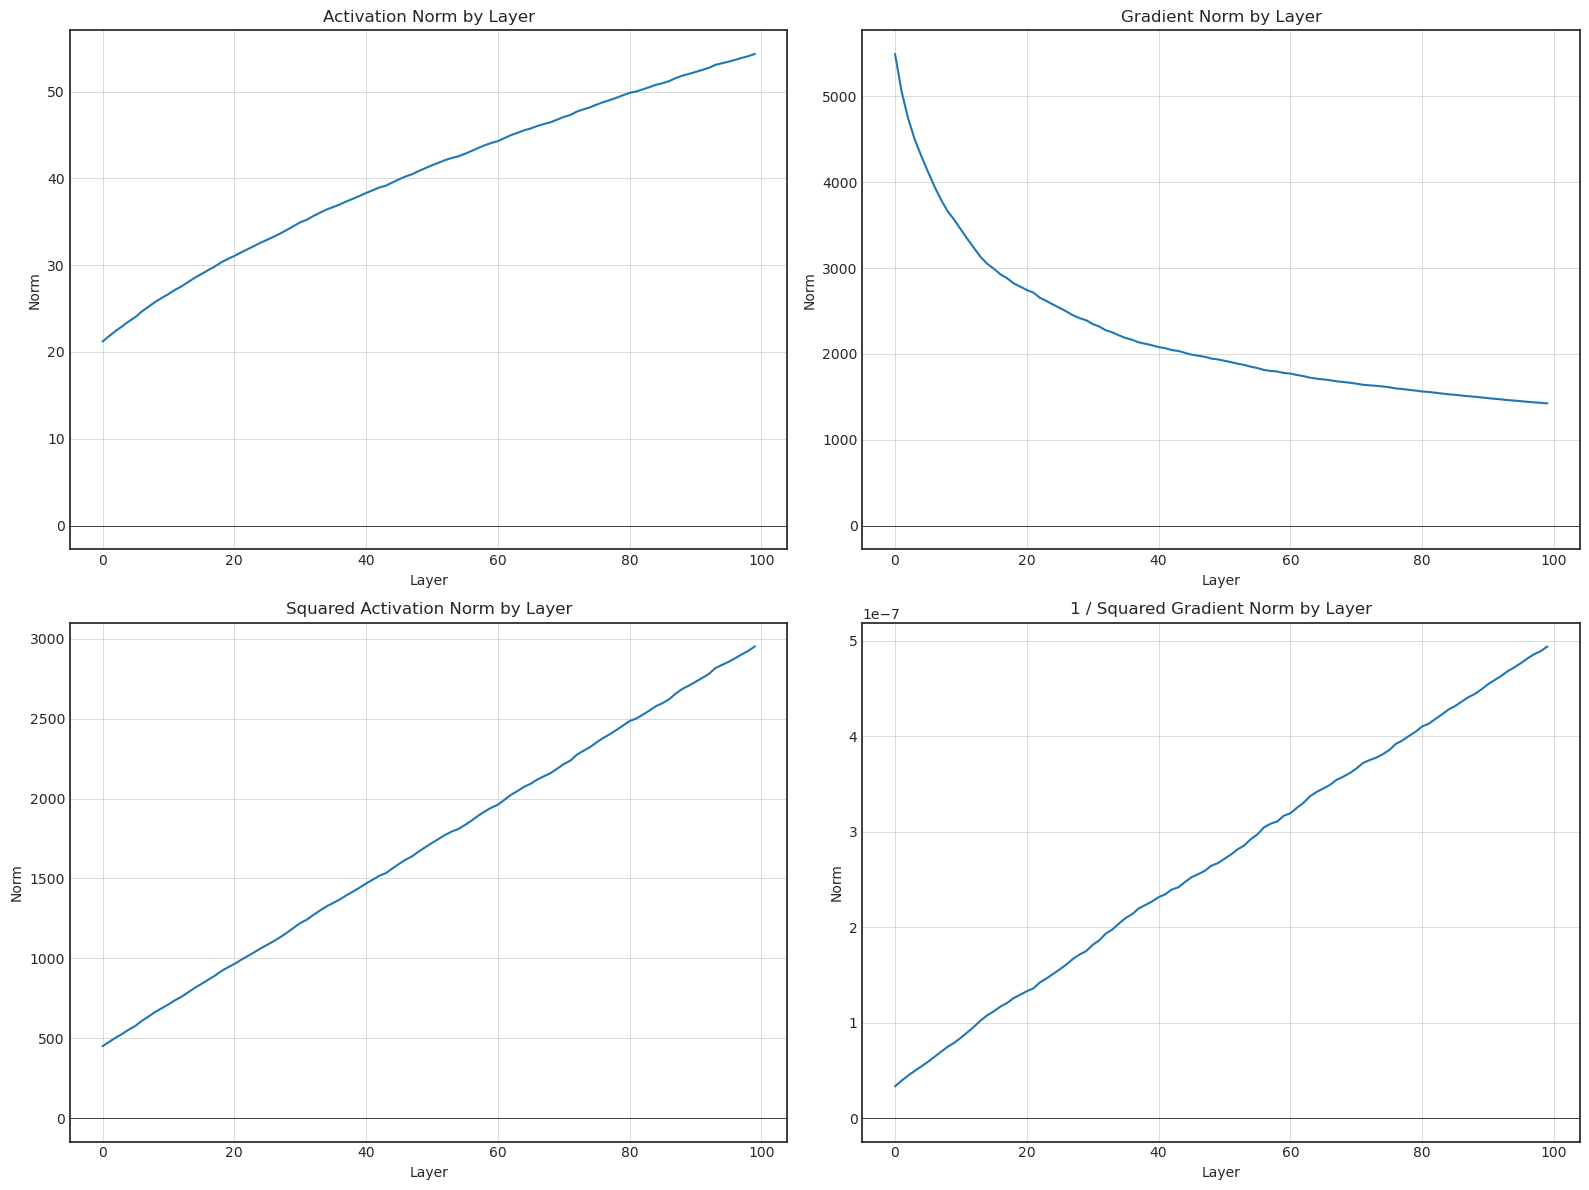

In [11]:
activation_and_gradient_norm_by_layer(n_layers=100, input_std=1.0)

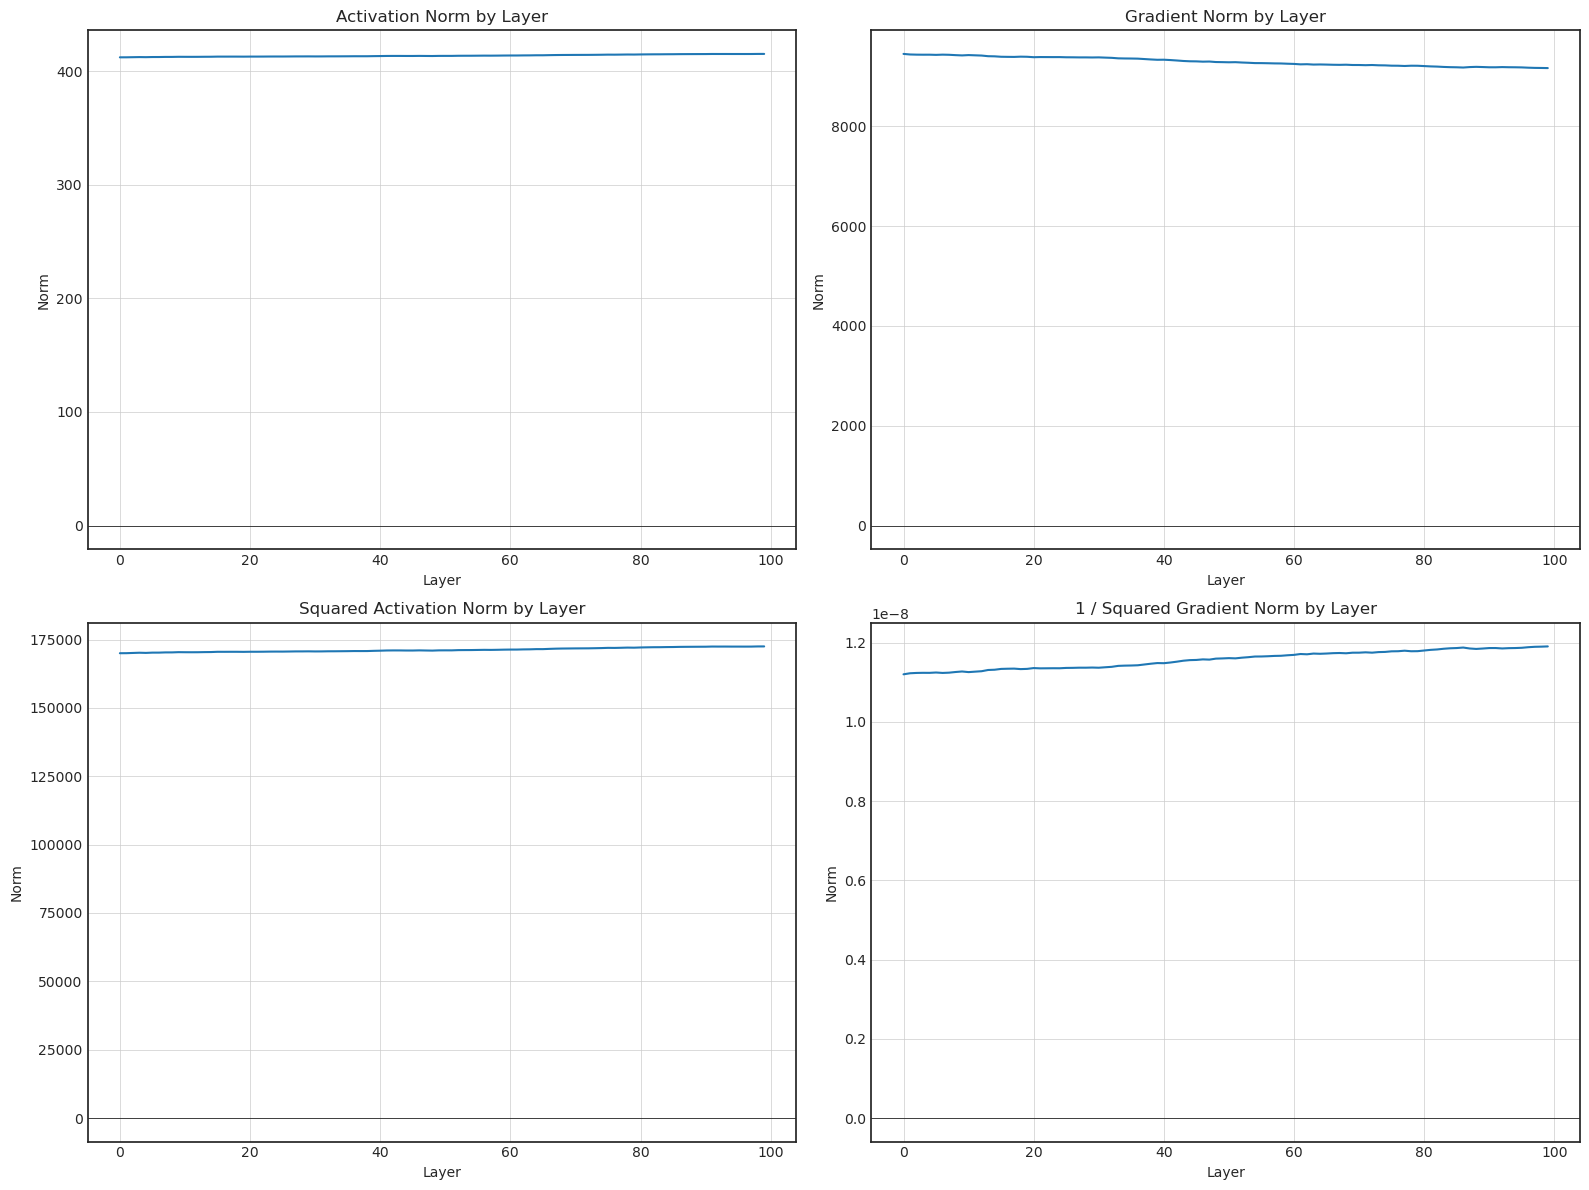

In [14]:
# To match the qualitative behaviour of GPT2
activation_and_gradient_norm_by_layer(n_layers=100, input_std=20)

> Fun exercise: reason through why for each output `o` of layer i in an L-layer ResNet as initialized above, (1) `norm(o)**2 ~ 1 + i/L` (2) `norm(o.grad)**2 ~ 2L / (L + i)`

### (3) Total Gradient Norm vs Num Layers

In [17]:
def total_activation_and_gradient_norm(n_layers_list: List[int], input_std: float, n_trials: int = 10):

    grad_norm_df = pd.DataFrame()
    
    for trial in range(n_trials):
        for n_layers in n_layers_list:
            embed_dim = 128
            
            model = ResNet(n_layers, embed_dim)
            model.init_weights()
            
            x = candle.rand(10, embed_dim) * input_std
            y = candle.rand(10, embed_dim)
            
            output = model(x)
            
            loss = ((output - y) ** 2).sum()
            
            loss.backward()
            
            grad_norm = np.sqrt(np.sum([np.linalg.norm(layer.linear.W.grad) ** 2 for layer in model.layers]))
            
            grad_norm_df.loc[n_layers, trial] = grad_norm
    
    fig = plt.figure(figsize=(16, 8))
    
    ax = fig.add_subplot(1, 2, 1)
    
    grad_norm_df.mean(axis=1).plot(ax=ax)
    ax.axhline(0, color='black', linewidth=0.5)
    ax.set_xlabel('# Layers')
    ax.set_ylabel('Norm')
    ax.set_title('Total Gradient Norm')
    ax.grid(linewidth=0.5)
    
    ax = fig.add_subplot(1, 2, 2)
    
    np.square(grad_norm_df.mean(axis=1)).plot(ax=ax)
    ax.axhline(0, color='black', linewidth=0.5)
    ax.set_xlabel('# Layers')
    ax.set_ylabel('Norm')
    ax.set_title('Squared Total Gradient Norm')
    ax.grid(linewidth=0.5)
    
    plt.tight_layout()
    plt.show()

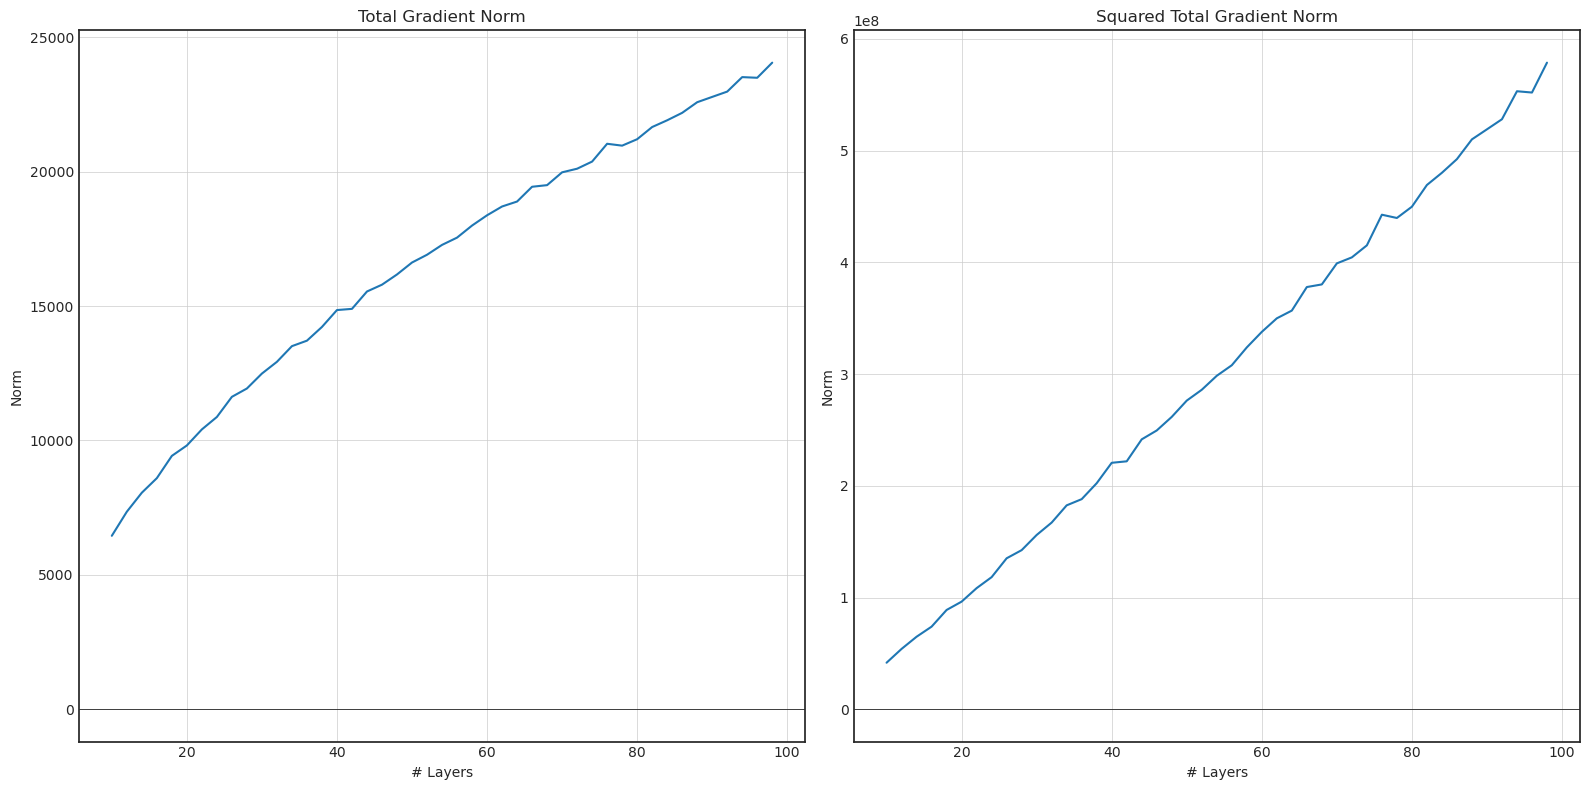

In [18]:
total_activation_and_gradient_norm(n_layers_list=list(range(10, 100, 2)), input_std=1.0, n_trials=50)

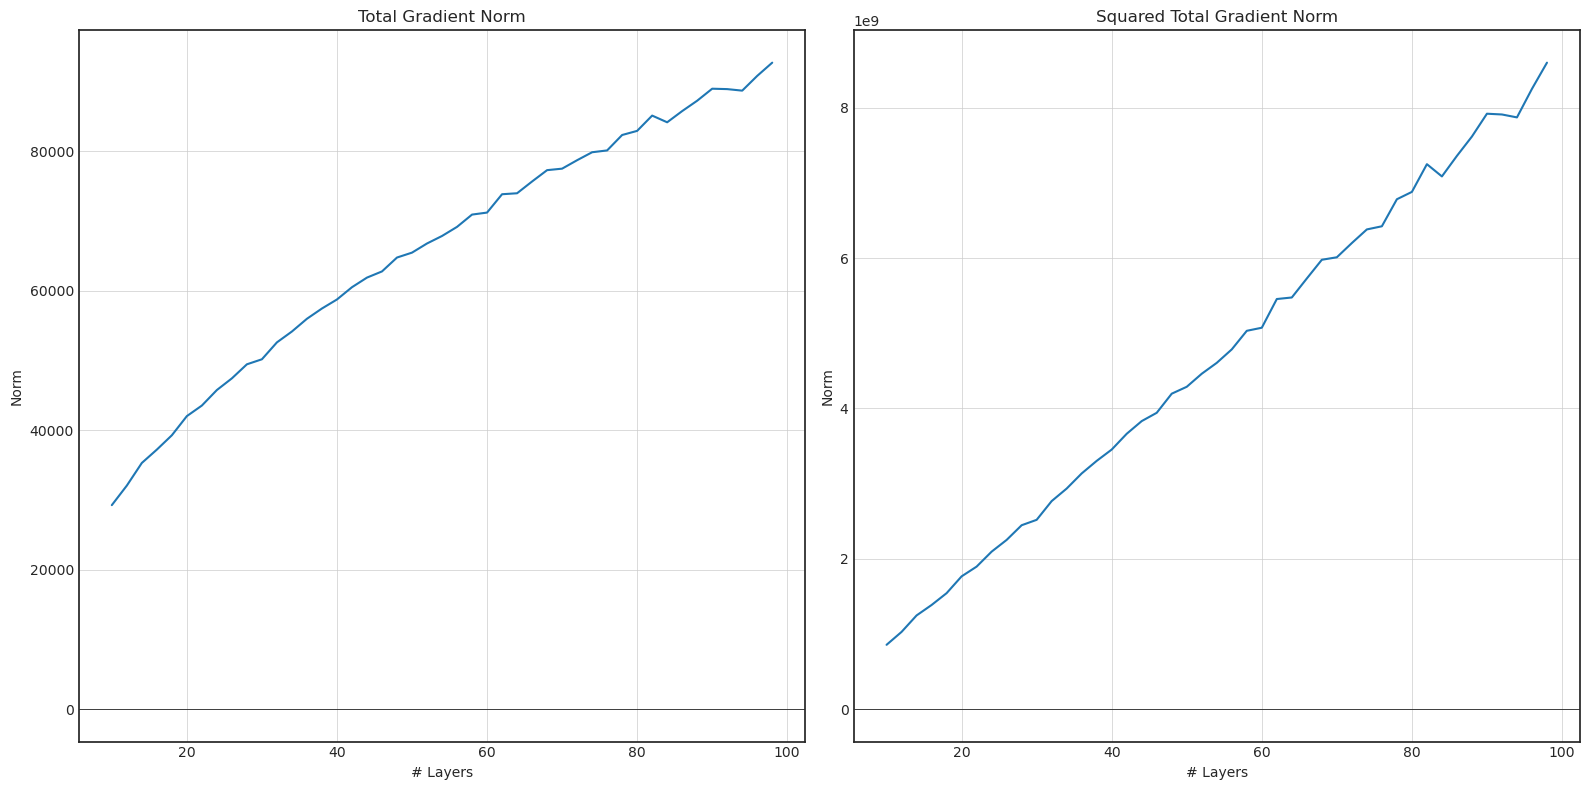

In [19]:
total_activation_and_gradient_norm(n_layers_list=list(range(10, 100, 2)), input_std=20, n_trials=50)